# Sleep & Academic Performance (ML Mini Project)

This notebook is part of my GDSC AI/ML induction task.  
I’m using a sleep-related student survey dataset and trying to see how sleep patterns affect academic performance (rated 1–5).  
Nothing too complicated here — just cleaning the data, doing some quick EDA, and running a couple of regression models.


## Loading the Dataset



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df = pd.read_csv("Student Insomnia and Educational Outcomes Dataset.csv")
df.head()


,Timestamp,1. What is your year of study?,2. What is your gender?,3. How often do you have difficulty falling asleep at night?,"4. On average, how many hours of sleep do you get on a typical day?",5. How often do you wake up during the night and have trouble falling back asleep?,6. How would you rate the overall quality of your sleep?,7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?,"8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?","9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?",10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?,"11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?","12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?",13. How often do you engage in physical activity or exercise?,14. How would you describe your stress levels related to academic workload?,15. How would you rate your overall academic performance (GPA or grades) in the past semester?
0,10/24/2024 16:51:15,Graduate student,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Sometimes,Often,Often (3-4 times a week),Moderate impact,Often (5-6 times a week),Rarely (1-2 times a week),Sometimes (3-4 times a week),High stress,Average
1,10/24/2024 16:51:51,Third year,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Often,Sometimes,Sometimes (1-2 times a week),Major impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Sometimes (3-4 times a week),Low stress,Good
2,10/24/2024 16:52:21,First year,Female,Sometimes (3-4 times a week),7-8 hours,Sometimes (3-4 times a week),Good,Often,Often,Sometimes (1-2 times a week),Major impact,Often (5-6 times a week),Often (5-6 times a week),Often (5-6 times a week),High stress,Below Average
3,10/24/2024 16:53:00,Third year,Male,Often (5-6 times a week),More than 8 hours,Sometimes (3-4 times a week),Poor,Often,Often,Rarely (1-2 times a month),Minor impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Every day,Extremely high stress,Excellent
4,10/24/2024 16:53:25,Graduate student,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Very good,Always,Sometimes,Sometimes (1-2 times a week),Moderate impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Often (5-6 times a week),Low stress,Average


##  Data Cleaning

The dataset mostly had text responses (“Often”, “Rarely”, “7–8 hours”, etc.), so I converted everything into numbers.

- Renamed the long question columns  
- Converted sleep hour ranges into numeric values  
- Mapped frequencies (Never → 1, Always → 5)  
- Converted sleep quality and stress into numeric scales  
- Dropped a few rows with missing values

After this step, the data was finally usable for ML.



In [21]:



df = pd.read_csv("Student Insomnia and Educational Outcomes Dataset.csv")


df = df.rename(columns={
    'Timestamp': 'timestamp',
    '1. What is your year of study?': 'year_of_study',
    '2. What is your gender?': 'gender',
    '3. How often do you have difficulty falling asleep at night? ': 'insomnia_freq',
    '4. On average, how many hours of sleep do you get on a typical day?': 'sleep_hours',
    '5. How often do you wake up during the night and have trouble falling back asleep?': 'night_wakeup',
    '6. How would you rate the overall quality of your sleep?': 'sleep_quality',
    '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?': 'concentration_diff',
    '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?': 'fatigue_freq',
    '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?': 'miss_classes',
    '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?': 'insufficient_sleep_impact',
    '11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?': 'device_usage',
    '12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?': 'caffeine_consumption',
    '13. How often do you engage in physical activity or exercise?': 'physical_activity',
    '14. How would you describe your stress levels related to academic workload?': 'stress_level',
    '15. How would you rate your overall academic performance (GPA or grades) in the past semester?': 'academic_performance'
})


def map_sleep_hours(v):
    if not isinstance(v, str):
        return None
    v = v.strip()
    if "Less than 4" in v:
        return 4
    if "4-5" in v or "4–5" in v:
        return 4.5
    if "6-7" in v or "6–7" in v:
        return 6.5
    if "7-8" in v or "7–8" in v:
        return 7.5
    if "More than 8" in v:
        return 9
    return None

df['sleep_hours'] = df['sleep_hours'].apply(map_sleep_hours)


performance_map = {
    'Excellent': 5,
    'Good': 4,
    'Average': 3,
    'Below Average': 2,
    'Poor': 1
}
df['academic_performance'] = df['academic_performance'].map(performance_map)


def map_freq5(v):
    if not isinstance(v, str):
        return None
    v = v.strip()
    if v.startswith("Never"):
        return 1
    if v.startswith("Rarely"):
        return 2
    if v.startswith("Sometimes"):
        return 3
    if v.startswith("Often"):
        return 4
    if v.startswith("Always") or v.startswith("Every night"):
        return 5
    return None


for col in ['insomnia_freq', 'night_wakeup', 'concentration_diff', 'fatigue_freq']:
    df[col] = df[col].apply(map_freq5)


sleep_quality_map = {
    'Very poor': 1,
    'Poor': 2,
    'Average': 3,
    'Good': 4,
    'Very good': 5
}
df['sleep_quality'] = df['sleep_quality'].map(sleep_quality_map)


stress_map = {
    'Low stress': 1,
    'Moderate stress': 2,
    'High stress': 3,
    'Extremely high stress': 4
}
df['stress_level'] = df['stress_level'].map(stress_map)


cols_to_check = [
    'sleep_hours', 'insomnia_freq', 'night_wakeup',
    'sleep_quality', 'concentration_diff', 'fatigue_freq',
    'stress_level', 'academic_performance'
]
print(df[cols_to_check].head())
print("\nNaNs per column:\n", df[cols_to_check].isna().sum())


   sleep_hours  insomnia_freq  night_wakeup  sleep_quality  \
0          7.5              4             4              4   
1          7.5              4             4              4   
2          7.5              3             3              4   
3          9.0              4             3              2   
4          7.5              4             4              5   

   concentration_diff  fatigue_freq  stress_level  academic_performance  
0                   3             4           3.0                     3  
1                   4             3           1.0                     4  
2                   4             4           3.0                     2  
3                   4             4           4.0                     5  
4                   5             3           1.0                     3  

NaNs per column:
 sleep_hours             0
insomnia_freq           0
night_wakeup            0
sleep_quality           0
concentration_diff      0
fatigue_freq            0
stress_l

In [22]:

df = df.dropna(subset=['stress_level'])

print(df.shape)
df[cols_to_check].describe()


(785, 16)


,sleep_hours,insomnia_freq,night_wakeup,sleep_quality,concentration_diff,fatigue_freq,stress_level,academic_performance
count,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000
mean,8.056688,4.366879,4.308280,2.941401,4.152866,4.177070,3.357962,1.601274
std,0.899424,0.707412,0.686417,1.627766,0.753949,0.752875,0.762994,0.766152
min,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,7.500000,4.000000,4.000000,1.000000,4.000000,4.000000,3.000000,1.000000
50%,7.500000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,1.000000
75%,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,2.000000
max,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000


## Exploratory Data Analysis (EDA)
Data analysis is done in this section

Just checking basic patterns:

- How many hours students usually sleep  
- How academic performance is distributed  
- Whether sleep hours/quality show any visible trend with performance  
- Quick correlation heatmap to see what relates to what

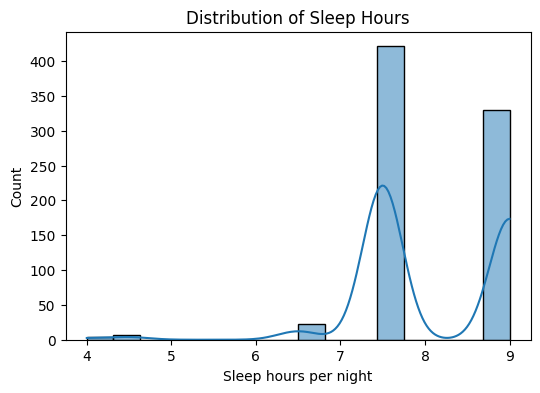

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df['sleep_hours'], kde=True)
plt.xlabel("Sleep hours per night")
plt.title("Distribution of Sleep Hours")
plt.show()


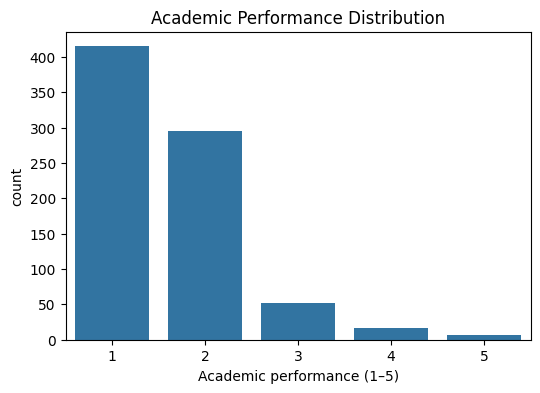

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['academic_performance'])
plt.xlabel("Academic performance (1–5)")
plt.title("Academic Performance Distribution")
plt.show()


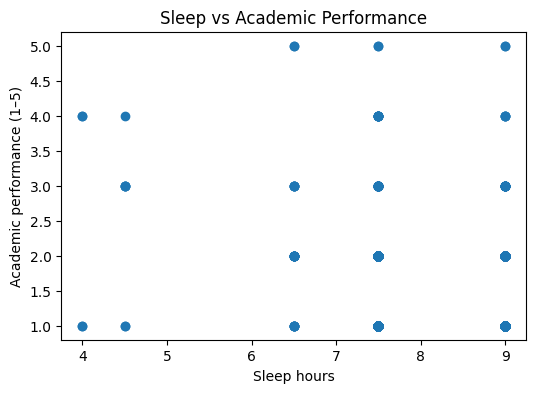

In [25]:
plt.figure(figsize=(6,4))
plt.scatter(df['sleep_hours'], df['academic_performance'])
plt.xlabel("Sleep hours")
plt.ylabel("Academic performance (1–5)")
plt.title("Sleep vs Academic Performance")
plt.show()


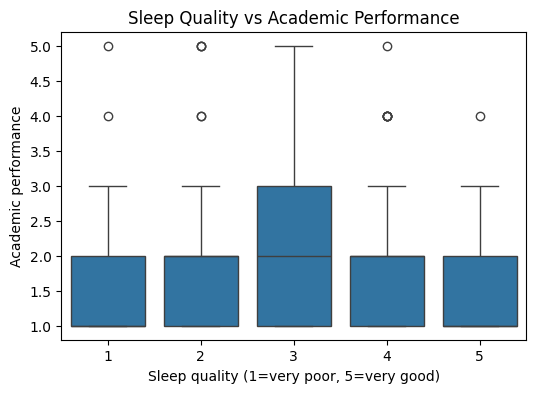

In [26]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['sleep_quality'], y=df['academic_performance'])
plt.xlabel("Sleep quality (1=very poor, 5=very good)")
plt.ylabel("Academic performance")
plt.title("Sleep Quality vs Academic Performance")
plt.show()


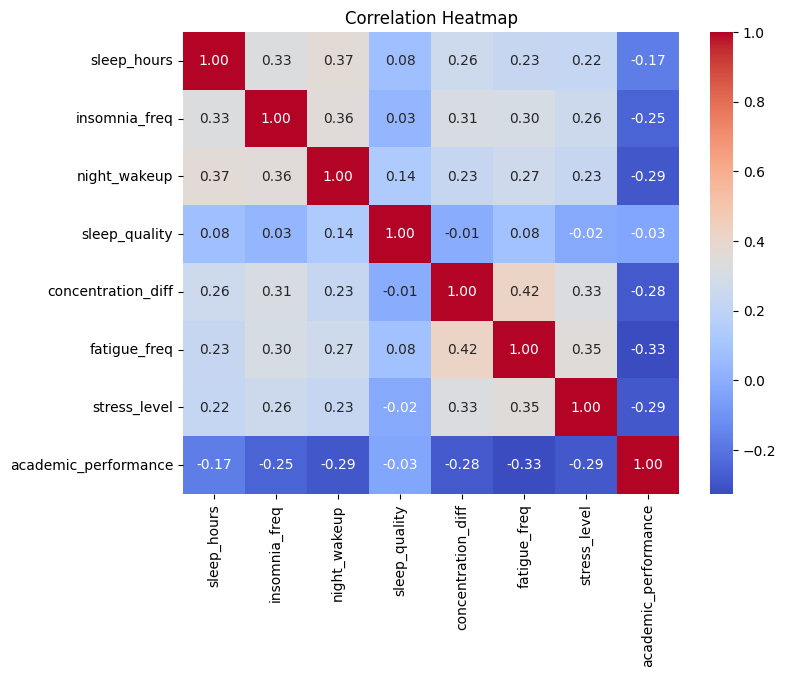

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(df[cols_to_check].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## Linear Regression Model

Using all the numeric sleep/stress features to predict academic performance.



In [28]:
features = [
    'sleep_hours',
    'insomnia_freq',
    'night_wakeup',
    'sleep_quality',
    'concentration_diff',
    'fatigue_freq',
    'stress_level'
]

X = df[features]
y = df['academic_performance']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, y_pred)
lin_r2 = r2_score(y_test, y_pred)

print("Linear Regression MAE:", lin_mae)
print("Linear Regression R²:", lin_r2)


Linear Regression MAE: 0.5201439612852957
Linear Regression R²: 0.2854522388448507


/Users/ankushkumar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ankushkumar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ankushkumar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


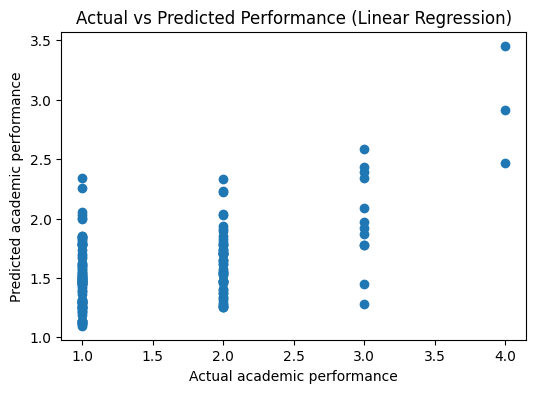

In [29]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual academic performance")
plt.ylabel("Predicted academic performance")
plt.title("Actual vs Predicted Performance (Linear Regression)")
plt.show()


## Random Forest Regressor

Tried Random Forest to see if a non-linear model performs better.  
Also used it to check feature importance.



In [30]:


rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest MAE:", rf_mae)
print("Random Forest R²:", rf_r2)


Random Forest MAE: 0.5291958568742527
Random Forest R²: 0.11426691474191886


In [31]:

importances = rf_model.feature_importances_
for feat, imp in sorted(zip(features, importances), key=lambda x: -x[1]):
    print(feat, ":", round(imp, 3))


sleep_quality : 0.183
night_wakeup : 0.166
fatigue_freq : 0.161
insomnia_freq : 0.143
stress_level : 0.123
concentration_diff : 0.12
sleep_hours : 0.103


## Results

**Linear Regression**
- MAE was ~0.52  
- R² was around 0.28  
So the model explains roughly 25–30% of the variation. Not great, but okay for survey data.

**Random Forest**
- MAE was similar  
- R² was worse  
Probably because the dataset is small and mostly linear, so RF didn’t find anything extra.

**Important Features (from RF)**
- Sleep quality
- Night wakeups
- Fatigue
- Insomnia  
Sleep hours mattered but not as much as I expected.
